In [17]:
from zipfile import ZipFile as zipfile
file_name = 'wgan_gp.zip'

with zipfile(file_name, 'r') as zip_file:
  zip_file.extractall()

In [5]:
import torch
import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder
import os
import torch.nn as nn
from matplotlib import pyplot as plt
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split

device = "cuda" if torch.cuda.is_available() else "cpu"

# ImageFolder class looks for images within folders (a folder for each class)
data_real = os.path.abspath(os.getcwd()) + "/wgan_gp/real"
data_fake = os.path.abspath(os.getcwd()) + "/wgan_gp/fake"

img_size = 64

data_real = ImageFolder(data_real,transform = transforms.Compose([ transforms.Resize((img_size,img_size)),transforms.ToTensor()]))

data_fake = ImageFolder(data_fake, transform = transforms.Compose([transforms.Resize((img_size,img_size)), transforms.ToTensor()]))

In [6]:
samples_num = len(data_real)
test_num = int(samples_num * 0.3) 
train_num = samples_num - test_num 

train_data, test_data = random_split(data_real, [train_num, test_num])

validation_num = int(test_num * 0.5) 
test_num = test_num - validation_num

validation_data, test_data = random_split(test_data, [validation_num, test_num])

len(train_data), len(validation_data), len(test_data)

(517, 110, 111)

In [7]:
batch_size = 256
num_workers = 2

train_data = DataLoader(train_data, batch_size, shuffle = True, num_workers = num_workers, pin_memory = True)
validation_data = DataLoader(validation_data, batch_size*2, num_workers = num_workers, pin_memory = True)
test_data = DataLoader(test_data, batch_size, shuffle = True, num_workers = num_workers, pin_memory = True)

In [8]:
import torch.nn as nn

class ClassificationBase(nn.Module):
    
    def training_step(self, batch):
        images, y = batch 
        predictions = self(images)
        loss = torch.nn.functional.cross_entropy(predictions, y)
        return loss
    
    def validation_step(self, batch):
        images, y = batch 
        predictions = self(images)
        loss = torch.nn.functional.cross_entropy(predictions, y)
        acc = accuracy(predictions, y)
        return {'test_loss': loss.detach(), 'test_accuracy': acc}

In [9]:
class ClassificationModel(ClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.Conv2d(32,64, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
        
            nn.Conv2d(64, 128, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(128 ,128, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            
            nn.Flatten(),
            nn.Linear(32768, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128,6)
        )
    
    def forward(self, xb):
        return self.network(xb)

In [10]:
def accuracy(predictions, y):
    _, preds = torch.max(predictions, dim=1)
    return torch.tensor(torch.sum(preds == y).item() / len(preds))
  
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    
    batch_losses = [x['test_loss'] for x in outputs]
    epoch_loss = torch.stack(batch_losses).mean()
    batch_accuracies = [x['test_accuracy'] for x in outputs]
    epoch_accuracy = torch.stack(batch_accuracies).mean()
    return {'test_loss': epoch_loss.item(), 'test_accuracy': epoch_accuracy.item()}

  
def fit(epochs, lr, model, train_set, test_set, opt_func = torch.optim.SGD):
    
    losses = []
    optimizer = opt_func(model.parameters(),lr)
    for epoch in range(epochs):
        
        model.train()
        train_losses = []
        for batch in train_set:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        result = evaluate(model, test_set)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        losses.append(result)

        print("Epoch: {}, train loss: {:.5f}, test loss: {:.5f}, test accuracy: {:.5f}".format(
            epoch + 1, result['train_loss'], result['test_loss'], result['test_accuracy']))
    
    return losses

In [ ]:
num_epochs = 20
opt_func = torch.optim.Adam
lr = 0.001

model = ClassificationModel()

losses = fit(num_epochs, lr, model, train_data, validation_data, opt_func)

Epoch: 0, train loss: 1.40897, validation loss: 1.69203, validation accuracy: 0.52727
Epoch: 1, train loss: 1.12306, validation loss: 1.06009, validation accuracy: 0.47273
Epoch: 2, train loss: 0.92605, validation loss: 0.97859, validation accuracy: 0.47273
Epoch: 3, train loss: 0.92322, validation loss: 0.78602, validation accuracy: 0.47273
Epoch: 4, train loss: 0.74068, validation loss: 0.69791, validation accuracy: 0.52727
Epoch: 5, train loss: 0.75632, validation loss: 0.71017, validation accuracy: 0.52727
Epoch: 6, train loss: 0.69692, validation loss: 0.68076, validation accuracy: 0.47273
Epoch: 7, train loss: 0.63401, validation loss: 0.78334, validation accuracy: 0.47273
Epoch: 8, train loss: 0.75328, validation loss: 0.58378, validation accuracy: 0.77273
Epoch: 9, train loss: 0.73257, validation loss: 0.65002, validation accuracy: 0.52727
Epoch: 10, train loss: 0.63809, validation loss: 0.59787, validation accuracy: 0.82727
Epoch: 11, train loss: 0.61409, validation loss: 0.60

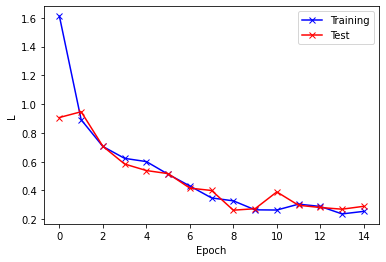

In [15]:
def plot_losses_per_epoch(losses):
    train_losses = [x.get('train_loss') for x in losses]
    val_losses = [x['test_loss'] for x in losses]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('Epoch')
    plt.ylabel('L')
    plt.legend(['Training', 'Test'])

plot_losses_per_epoch(losses)

In [ ]:
num_epochs = 15
opt_func = torch.optim.Adam
lr = 0.001

model = ClassificationModel()

losses = fit(num_epochs, lr, model, train_data, validation_data, opt_func)

Epoch: 0, train loss: 1.67930, validation loss: 0.78975, validation accuracy: 0.52727
Epoch: 1, train loss: 0.61379, validation loss: 4.76697, validation accuracy: 0.47273
Epoch: 2, train loss: 2.25837, validation loss: 1.08671, validation accuracy: 0.52727
Epoch: 3, train loss: 0.76441, validation loss: 0.71162, validation accuracy: 0.52727
Epoch: 4, train loss: 0.77359, validation loss: 0.84629, validation accuracy: 0.52727
Epoch: 5, train loss: 0.80137, validation loss: 0.69855, validation accuracy: 0.52727
Epoch: 6, train loss: 0.69384, validation loss: 0.62277, validation accuracy: 0.52727
Epoch: 7, train loss: 0.61781, validation loss: 0.51102, validation accuracy: 0.85455
Epoch: 8, train loss: 0.44456, validation loss: 0.42877, validation accuracy: 0.81818
Epoch: 9, train loss: 0.33489, validation loss: 0.33632, validation accuracy: 0.86364
Epoch: 10, train loss: 0.43463, validation loss: 0.31434, validation accuracy: 0.84545
Epoch: 11, train loss: 0.23295, validation loss: 0.52

In [ ]:
losses = evaluate(model, validation_data)
print(losses)

{'validation_loss': 0.3380294144153595, 'validation_accuracy': 0.8727272748947144}


In [ ]:
losses = evaluate(model, test_data)
print(losses)

{'validation_loss': 0.2717888355255127, 'validation_accuracy': 0.9009009003639221}


**Case 1:**

Train dataset: 80% Real MRI Scans

Test dataset: 20% Real MRI Scans

In [ ]:
test_num = int(samples_num * 0.2) 
train_num = samples_num - test_num 

train_data, test_data = random_split(data_real, [train_num, test_num])

train_data = DataLoader(train_data, batch_size, shuffle = True, num_workers = num_workers, pin_memory = True)
test_data = DataLoader(test_data, batch_size, shuffle = True, num_workers = num_workers, pin_memory = True)

num_epochs = 15
opt_func = torch.optim.Adam
lr = 0.001

model = ClassificationModel()

losses = fit(num_epochs, lr, model, train_data, test_data, opt_func)

Epoch: 1, train loss: 1.70442, test loss: 0.84412, test accuracy: 0.52381
Epoch: 2, train loss: 0.63126, test loss: 2.25293, test accuracy: 0.52381
Epoch: 3, train loss: 2.20088, test loss: 0.82480, test accuracy: 0.59184
Epoch: 4, train loss: 1.09902, test loss: 0.52907, test accuracy: 0.64626
Epoch: 5, train loss: 0.58163, test loss: 0.71291, test accuracy: 0.47619
Epoch: 6, train loss: 0.73286, test loss: 0.77752, test accuracy: 0.47619
Epoch: 7, train loss: 0.73801, test loss: 0.64529, test accuracy: 0.88435
Epoch: 8, train loss: 0.57617, test loss: 0.48108, test accuracy: 0.76871
Epoch: 9, train loss: 0.46881, test loss: 0.36326, test accuracy: 0.87075
Epoch: 10, train loss: 0.34449, test loss: 0.34099, test accuracy: 0.87755
Epoch: 11, train loss: 0.28874, test loss: 0.25470, test accuracy: 0.87755
Epoch: 12, train loss: 0.28392, test loss: 0.31862, test accuracy: 0.88435
Epoch: 13, train loss: 0.24488, test loss: 0.26766, test accuracy: 0.89796
Epoch: 14, train loss: 0.38859, te

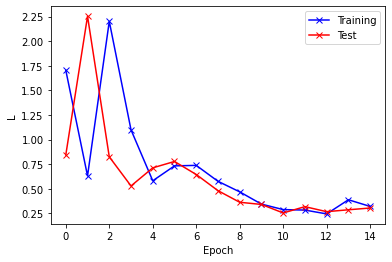

In [ ]:
plot_losses_per_epoch(losses)

Using 80% of the real MRI scnas as the training set and 20% of the real scans as the test set produce ≈ **90%** accuracy for 15 epochs

**Case 2:**

Train dataset: 80% Real MRI Scans + 100% synthetic MRI Scans generated using WGAN GP

Test dataset: 20% Real MRI Scans

Epoch: 1, train loss: 1.26980, test loss: 0.77957, test accuracy: 0.43537
Epoch: 2, train loss: 0.74731, test loss: 0.65378, test accuracy: 0.56463
Epoch: 3, train loss: 0.68431, test loss: 0.62171, test accuracy: 0.61905
Epoch: 4, train loss: 0.54998, test loss: 0.43399, test accuracy: 0.80952
Epoch: 5, train loss: 0.30477, test loss: 0.46693, test accuracy: 0.81633
Epoch: 6, train loss: 0.41473, test loss: 1.05570, test accuracy: 0.61905
Epoch: 7, train loss: 0.44665, test loss: 0.40236, test accuracy: 0.87075
Epoch: 8, train loss: 0.31791, test loss: 0.39224, test accuracy: 0.81633
Epoch: 9, train loss: 0.28198, test loss: 0.29913, test accuracy: 0.85714
Epoch: 10, train loss: 0.23909, test loss: 0.31301, test accuracy: 0.88435
Epoch: 11, train loss: 0.23499, test loss: 0.31065, test accuracy: 0.84354
Epoch: 12, train loss: 0.24475, test loss: 0.34068, test accuracy: 0.83673
Epoch: 13, train loss: 0.22703, test loss: 0.31846, test accuracy: 0.89116
Epoch: 14, train loss: 0.23729, te

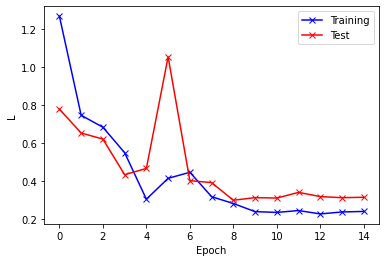

In [ ]:
test_num = int(samples_num * 0.2) 
train_num = samples_num - test_num 

train_data, test_data = random_split(data_real, [train_num, test_num])
train_data += data_fake

train_data = DataLoader(train_data, batch_size, shuffle = True, num_workers = num_workers, pin_memory = True)
test_data = DataLoader(test_data, batch_size, shuffle = True, num_workers = num_workers, pin_memory = True)

model = ClassificationModel()

losses = fit(num_epochs, lr, model, train_data, test_data, opt_func)

plot_losses_per_epoch(losses)

Using 80% of the real MRI scnas + 100% of the synthetic data as the training set and 20% of the real scans as the test set produce ≈ **86%** accuracy for 15 epochs

We would expect an improved performance, however, we can also notice that the loss on the training set in this case is lower than the training lose without adding the synthetic dataset. This may suggest that the model started to overfit the training set which increased its generaliztation error.


**Case 3:**


Train dataset: 100% Synthetic MRI Scans generated using WGAN GP

Test dataset: 100% Real MRI Scans

Epoch: 1, train loss: 1.46338, test loss: 1.21742, test accuracy: 0.49965
Epoch: 2, train loss: 0.91901, test loss: 0.78548, test accuracy: 0.49948
Epoch: 3, train loss: 0.74692, test loss: 0.69843, test accuracy: 0.50121
Epoch: 4, train loss: 0.69533, test loss: 0.67501, test accuracy: 0.49948
Epoch: 5, train loss: 0.64652, test loss: 0.64786, test accuracy: 0.50052
Epoch: 6, train loss: 0.62040, test loss: 0.56659, test accuracy: 0.64260
Epoch: 7, train loss: 0.54042, test loss: 0.44717, test accuracy: 0.81262
Epoch: 8, train loss: 0.41289, test loss: 0.32335, test accuracy: 0.89837
Epoch: 9, train loss: 0.35235, test loss: 0.45545, test accuracy: 0.80428
Epoch: 10, train loss: 0.47318, test loss: 0.31053, test accuracy: 0.88500
Epoch: 11, train loss: 0.31038, test loss: 0.35089, test accuracy: 0.86374
Epoch: 12, train loss: 0.27051, test loss: 0.30039, test accuracy: 0.89013
Epoch: 13, train loss: 0.24405, test loss: 0.30743, test accuracy: 0.87363
Epoch: 14, train loss: 0.25131, te

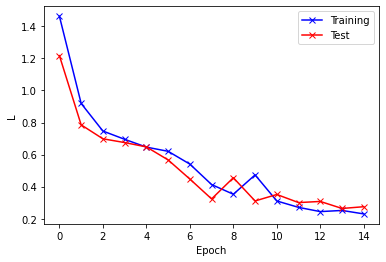

In [ ]:
train_data = DataLoader(data_fake, batch_size, shuffle = True, num_workers = num_workers, pin_memory = True)
test_data = DataLoader(data_real, batch_size, shuffle = True, num_workers = num_workers, pin_memory = True)

model = ClassificationModel()

losses = fit(num_epochs, lr, model, train_data, test_data, opt_func)

plot_losses_per_epoch(losses)

Using 100% of the synthetic MRI scnas as the training set and 100% of the real scans produce ≈ **88%** accuracy for 15 epochs. 

Accuracy was around 90% in the first case, which is only slightly higher than the accuracy of the model that was trained on synthetic data only.

This proves that synthetic data is able to train models with comparable performance to models trained on real data.

(Note: 100% of the synthetic samples were used in this case, which is 20% higher than the amount of data used in case 1. At the same time, the test set is 5 times larger in this case, meaning that generalization was tested more than the model's generalization in case 1).

**Case 4:**

Train dataset: 50% Real MRI Scans + 50% synthetic MRI Scans generated using WGAN GP

Test dataset: 50% Real MRI Scans

Epoch: 1, train loss: 1.60275, test loss: 0.76923, test accuracy: 0.48308
Epoch: 2, train loss: 0.95506, test loss: 0.92785, test accuracy: 0.48802
Epoch: 3, train loss: 0.75782, test loss: 0.65948, test accuracy: 0.51939
Epoch: 4, train loss: 0.69111, test loss: 0.68738, test accuracy: 0.50703
Epoch: 5, train loss: 0.67367, test loss: 0.61550, test accuracy: 0.65647
Epoch: 6, train loss: 0.58904, test loss: 0.52525, test accuracy: 0.88089
Epoch: 7, train loss: 0.47584, test loss: 0.39211, test accuracy: 0.85251
Epoch: 8, train loss: 0.36279, test loss: 0.47911, test accuracy: 0.79770
Epoch: 9, train loss: 0.33901, test loss: 0.28616, test accuracy: 0.89273
Epoch: 10, train loss: 0.26438, test loss: 0.54173, test accuracy: 0.80448
Epoch: 11, train loss: 0.42465, test loss: 0.31877, test accuracy: 0.88285
Epoch: 12, train loss: 0.38654, test loss: 0.63354, test accuracy: 0.78886
Epoch: 13, train loss: 0.45230, test loss: 0.35496, test accuracy: 0.87308
Epoch: 14, train loss: 0.29802, te

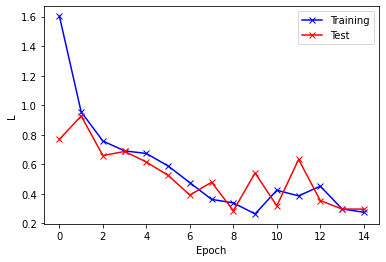

In [ ]:
test_num = int(samples_num * 0.5) 
train_num = samples_num - test_num 

train_data_real, test_data_real = random_split(data_real, [train_num, test_num])
train_data_fake, _ = random_split(data_fake, [train_num, test_num])

train_data = train_data_real + train_data_fake

train_data = DataLoader(train_data, batch_size, shuffle = True, num_workers = num_workers, pin_memory = True)
test_data = DataLoader(test_data_real, batch_size, shuffle = True, num_workers = num_workers, pin_memory = True)

model = ClassificationModel()

losses = fit(num_epochs, lr, model, train_data, test_data, opt_func)

plot_losses_per_epoch(losses)

This case was performed to test the assumption around overfitting of case 2. Here, 50% of the training sampels come from the real MRI scans, and 50% come from the synthetic images. The test set comes from the other 50% of the real scans. The model produced ≈ **89%** accuracy, which may assert that the model was actually overfitting the data. With further analysis, the model may be able to produce a better accuracy compared to the case when using only real MRI scans.

**Case 5:**

Train dataset: 100% Synthetic MRI Scans generated using DCGAN

Test dataset: 100% Real MRI Scans

In [18]:
from zipfile import ZipFile as zipfile
file_name = 'dcgan.zip'

with zipfile(file_name, 'r') as zip_file:
  zip_file.extractall()

In [12]:
data_real = os.path.abspath(os.getcwd()) + "/dcgan/real"
data_fake = os.path.abspath(os.getcwd()) + "/dcgan/fake"

img_size = 64

data_real = ImageFolder(data_real,transform = transforms.Compose([ transforms.Resize((img_size,img_size)),transforms.ToTensor()]))

data_fake = ImageFolder(data_fake, transform = transforms.Compose([transforms.Resize((img_size,img_size)), transforms.ToTensor()]))

Epoch: 1, train loss: 1.54562, test loss: 0.87390, test accuracy: 0.50086
Epoch: 2, train loss: 0.78370, test loss: 0.78041, test accuracy: 0.50328
Epoch: 3, train loss: 0.70895, test loss: 0.75178, test accuracy: 0.49879
Epoch: 4, train loss: 0.67148, test loss: 0.67573, test accuracy: 0.50190
Epoch: 5, train loss: 0.62515, test loss: 0.59423, test accuracy: 0.56240
Epoch: 6, train loss: 0.55320, test loss: 0.50114, test accuracy: 0.87311
Epoch: 7, train loss: 0.45939, test loss: 0.44653, test accuracy: 0.76489
Epoch: 8, train loss: 0.37347, test loss: 0.30276, test accuracy: 0.89689
Epoch: 9, train loss: 0.27146, test loss: 0.29463, test accuracy: 0.89099
Epoch: 10, train loss: 0.27569, test loss: 0.27873, test accuracy: 0.89672
Epoch: 11, train loss: 0.26397, test loss: 0.30619, test accuracy: 0.88274
Epoch: 12, train loss: 0.26244, test loss: 0.27571, test accuracy: 0.90097
Epoch: 13, train loss: 0.24474, test loss: 0.26825, test accuracy: 0.89576
Epoch: 14, train loss: 0.23755, te

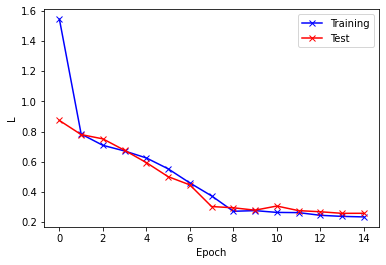

In [16]:
train_data = DataLoader(data_fake, batch_size, shuffle = True, num_workers = num_workers, pin_memory = True)
test_data = DataLoader(data_real, batch_size, shuffle = True, num_workers = num_workers, pin_memory = True)

num_epochs = 15
opt_func = torch.optim.Adam
lr = 0.001

model = ClassificationModel()

losses = fit(num_epochs, lr, model, train_data, test_data, opt_func)

plot_losses_per_epoch(losses)

Using 100% of the synthetic data generated by DCGAN as the training set and 100% of the real scans as the test set produce **≈ 90%** accuracy for 15 epochs.

The accuracies generally were slightly higher than the accuracy of the models trained on the synthetic images generated by WGAN GP.